1. Load the Required Libraries

In [1]:
import pandas as pd
import numpy as np
import dtale
import matplotlib.pyplot as plt
import seaborn as sns
import shap
shap.initjs()
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier as LightGradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_auc_score,recall_score

C:\Users\Frank\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\dtale\utils.py:18: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version
C:\Users\Frank\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



2. Read the data from the dataset

Dataset shape: (253680, 22)

Data types:
 Diabetes_binary         float64
HighBP                  float64
HighChol                float64
CholCheck               float64
BMI                     float64
Smoker                  float64
Stroke                  float64
HeartDiseaseorAttack    float64
PhysActivity            float64
Fruits                  float64
Veggies                 float64
HvyAlcoholConsump       float64
AnyHealthcare           float64
NoDocbcCost             float64
GenHlth                 float64
MentHlth                float64
PhysHlth                float64
DiffWalk                float64
Sex                     float64
Age                     float64
Education               float64
Income                  float64
dtype: object

Missing values:
 Diabetes_binary         0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity  

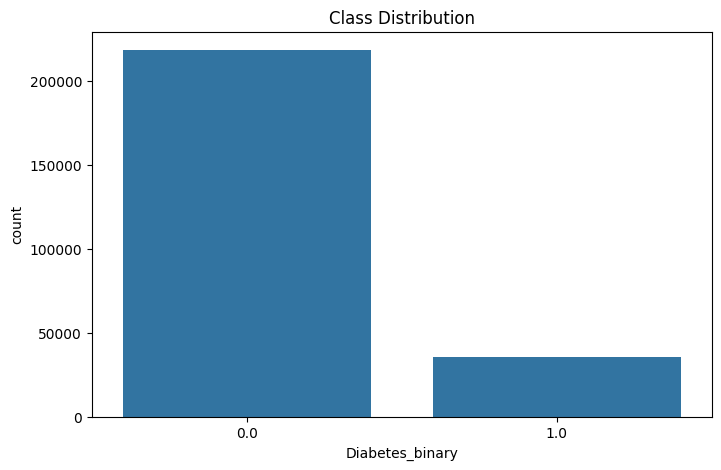

In [2]:
df = pd.read_csv("../../Datasets/diabetes_binary_health_indicators_BRFSS2015.csv", encoding='latin1')
# Initial data summary
print(f"Dataset shape: {df.shape}")
print("\nData types:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())

# Visualize class distribution
plt.figure(figsize=(8,5))
sns.countplot(x='Diabetes_binary', data=df)
plt.title('Class Distribution')
plt.show()

In [3]:
# Drop irrelevant columns
cols_to_drop = ['CholCheck','Smoker','Fruits','Veggies','HvyAlcoholConsump','AnyHealthcare','NoDocbcCost','MentHlth','Sex','Education']
print(f"Dropping columns: {cols_to_drop} as they are not relevant for prediction")
df.drop(columns=cols_to_drop, inplace=True)

Dropping columns: ['CholCheck', 'Smoker', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'MentHlth', 'Sex', 'Education'] as they are not relevant for prediction


In [4]:
print(df.isnull().sum())
print(df.isna().sum())
dtale.show(df)

Diabetes_binary         0
HighBP                  0
HighChol                0
BMI                     0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
GenHlth                 0
PhysHlth                0
DiffWalk                0
Age                     0
Income                  0
dtype: int64
Diabetes_binary         0
HighBP                  0
HighChol                0
BMI                     0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
GenHlth                 0
PhysHlth                0
DiffWalk                0
Age                     0
Income                  0
dtype: int64


4.Feature Engineering

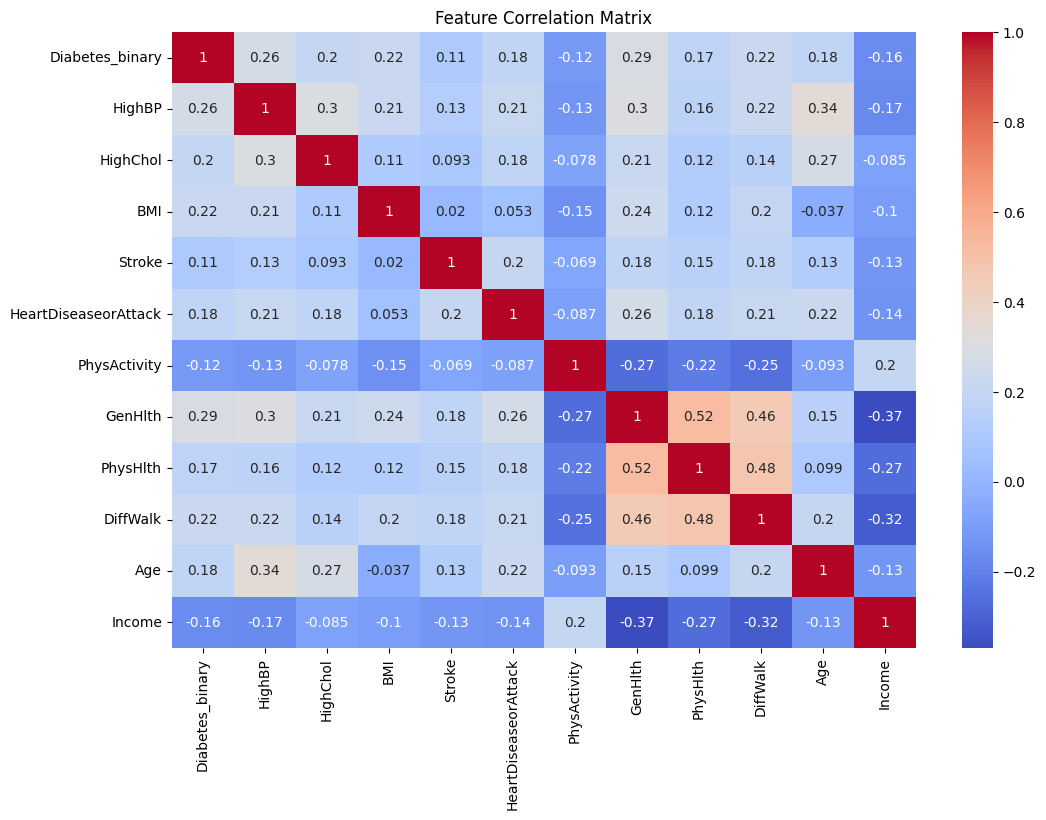

In [5]:
# Add feature correlation analysis
plt.figure(figsize=(12,8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

5. Split the attribites into dependent and independent attributes

In [ ]:
Y = df.iloc[:, 0]  # First column as target
X = df.iloc[:, 1:]  # All other columns as features
dtale.show(Y, ignore_duplicate=True)

6. Splitting the dataset intro training set and test set

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

7. Train the Light Gradient Model

In [ ]:
lightgradientboostparams = {
    'random_state':42}

In [ ]:
lgb = LightGradientBoostingClassifier(**lightgradientboostparams)
lgb.fit(X_train, Y_train,
          eval_set=[(X_test, Y_test)],
          )
y_pred_train = lgb.predict(X_test)
cm_train = confusion_matrix(Y_test, y_pred_train)
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test Data)')
plt.show()

# Display evaluation matrix (classification report)
report_train = classification_report(Y_test, y_pred_train, output_dict=True)
df_report_train = pd.DataFrame(report_train).transpose()
print(df_report_train)

In [ ]:
lightgradientboostparams = {
    
    'n_estimators': 1000,
    'criterion': 'entropy',
    'min_samples_split': 10,
    'random_state':42}

8. Retraining the model using Resampled data

In [ ]:
smote_enn = SMOTE(sampling_strategy='auto', random_state=42)
X_train_res, Y_train_res = smote_enn.fit_resample(X_train, Y_train)
print(pd.Series(Y_train_res).value_counts())

0.0    174809
1.0    174809
Name: count, dtype: int64


In [ ]:
model = LightGradientBoostingClassifier( random_state= 42)
model.fit(X_train_res, Y_train_res) 
Kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(model, X_train_res, Y_train_res, cv=Kfold, scoring='accuracy')

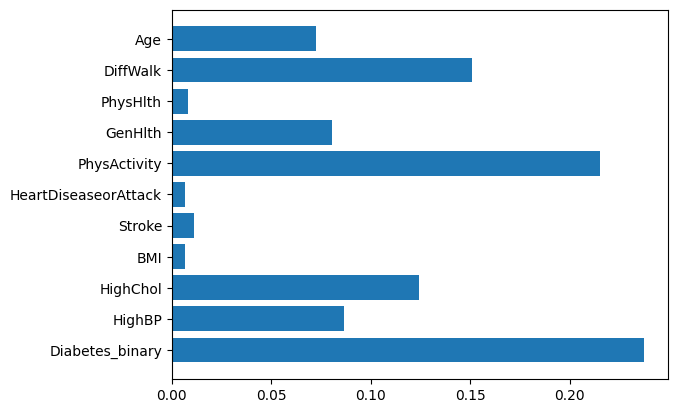

In [ ]:
importances = model.feature_importances_
features = df.columns[:-1]
plt.barh(features, importances)
plt.show()

              precision  recall  f1-score     support
0.0              0.8916  0.9411    0.9157  43525.0000
1.0              0.4657  0.3097    0.3720   7211.0000
accuracy         0.8514  0.8514    0.8514      0.8514
macro avg        0.6787  0.6254    0.6439  50736.0000
weighted avg     0.8311  0.8514    0.8384  50736.0000
ROC-AUC: 0.8127
Sensitivity: 0.3097
Specificity: 0.9411
Confusion Matrix:
[[40963  2562]
 [ 4978  2233]]
Mean Accuracy:0.8871 (+/- 0.0016)


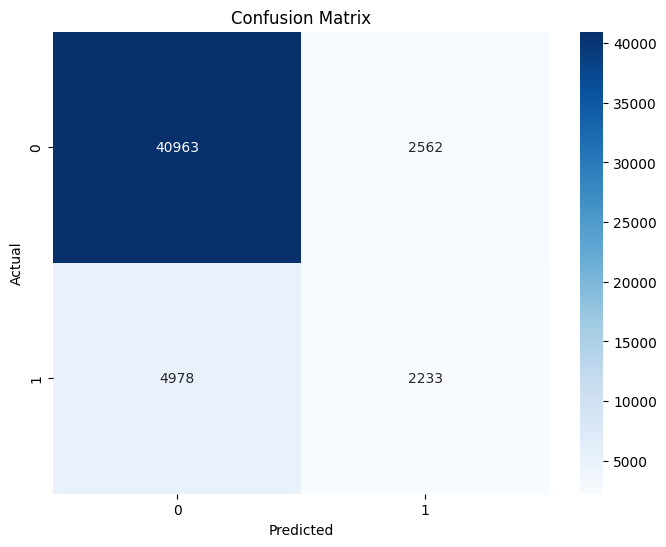

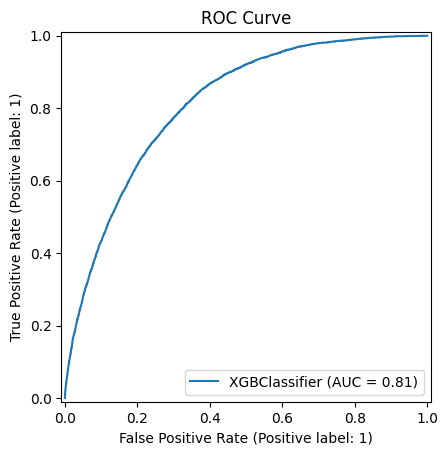

In [ ]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
sensitivity = recall_score(Y_test, y_pred, pos_label=1)
roc_auc = roc_auc_score(Y_test, y_proba)
cm = confusion_matrix(Y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)


report = classification_report(Y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()

pd.set_option("display.precision", 4)
print(df_report)
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Confusion Matrix:\n{confusion_matrix(Y_test, y_pred)}")
print(f"Mean Accuracy:{scores.mean():.4f} (+/- {scores.std():.4f})")# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
    
    # Plot ROC curve
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(model, X_test, Y_test)
plt.title('ROC Curve')
plt.show()

10.Feature Importance Visualization

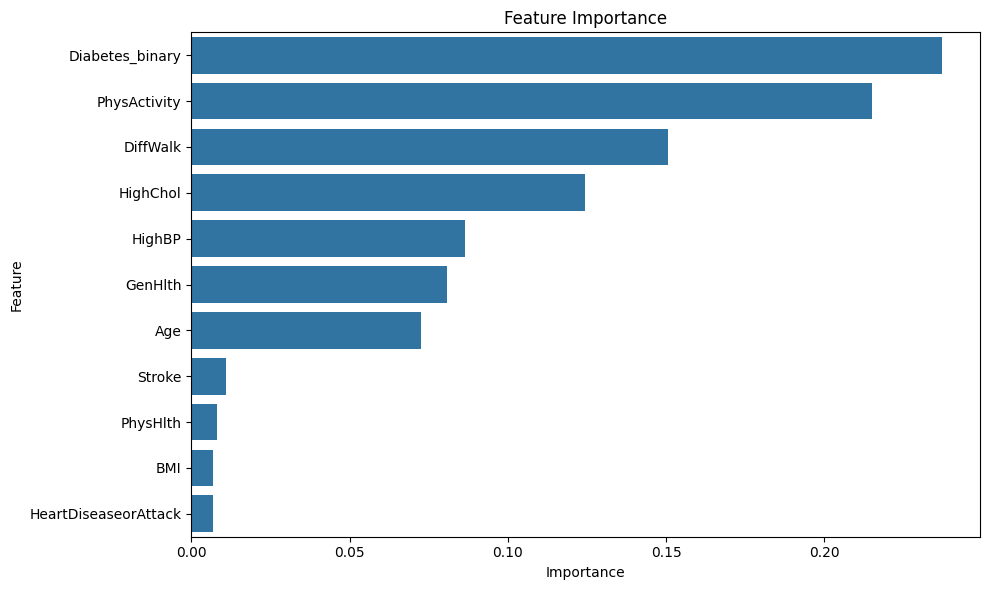

In [ ]:
# Feature importance analysis
importance = model.feature_importances_
features = df.columns[:-1]

# Create DataFrame and sort
feature_importance = pd.DataFrame({'Feature': features, 'Importance': importance})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

11. Apply Shapley Additive Technique to the data

In [ ]:
#get the SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X_train_res)
print(shap_values.shape)

(349618, 11)


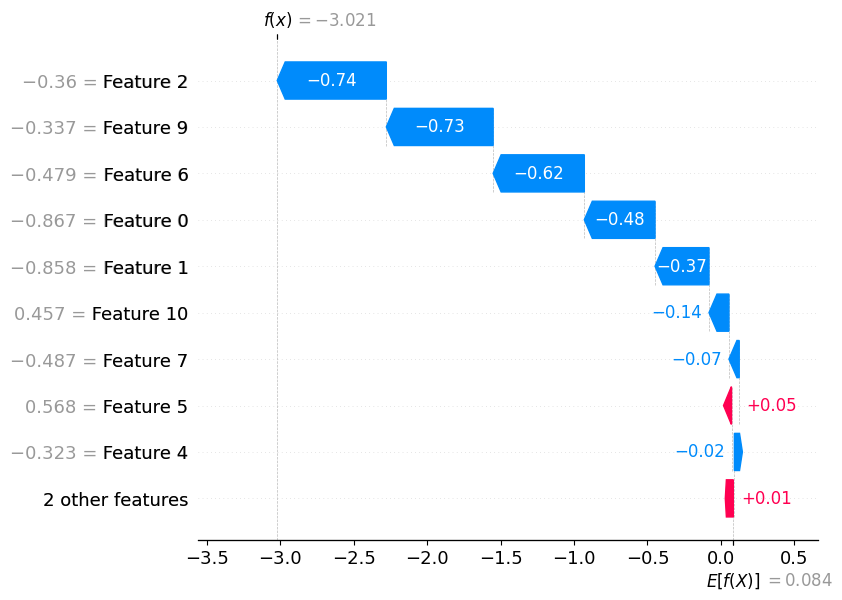

In [ ]:
#Waterfall plot for the first observation
shap.plots.waterfall(shap_values[0])

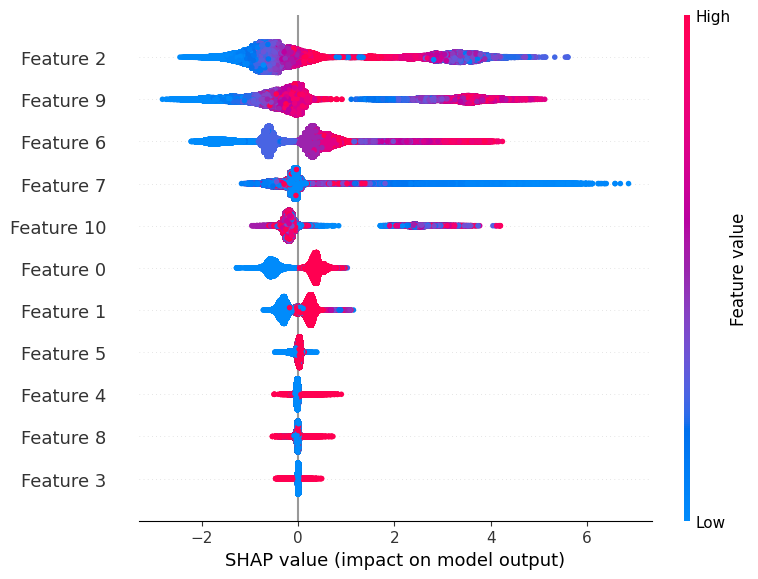

In [ ]:
shap.summary_plot(shap_values, X_train_res)